In [1]:
import pandas as pd

PATH = '/home/kai/data/kaggle/homecredit/'

train = pd.read_csv(PATH + 'application_train.csv')
test = pd.read_csv(PATH + 'application_test.csv')
inst = pd.read_csv(PATH + 'installments_payments.csv')

# Cut at the second year pior to application
# inst = inst[inst.DAYS_INSTALMENT>=-365*2 ]
inst = inst[inst.DAYS_INSTALMENT<=-365*2 ]
print(inst.shape)

'done'

(7326689, 8)


'done'

In [10]:
import os
x = os.listdir(PATH + 'submission')

/home/kai/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/kai/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


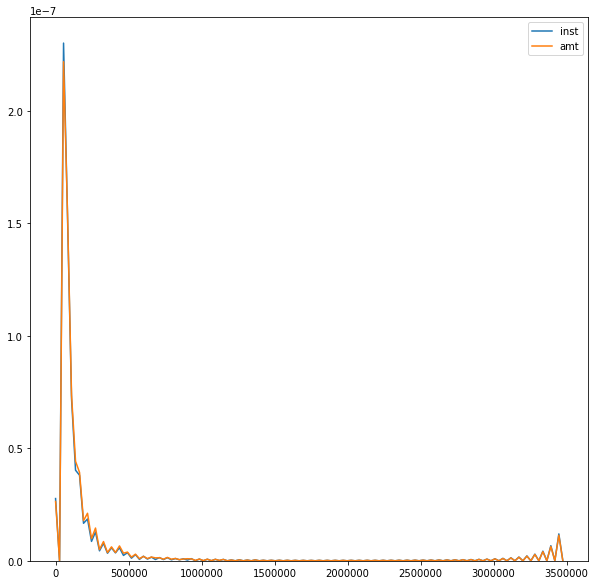

In [17]:
import seaborn as sns
plt.figure(figsize = (10,10))
sns.kdeplot(inst.AMT_INSTALMENT, label = 'inst')
sns.kdeplot(inst.AMT_PAYMENT, label = 'amt')

In [11]:
type(x)

list

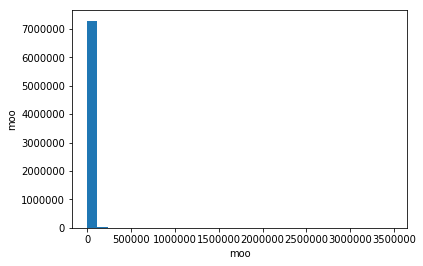

In [6]:
import matplotlib.pyplot as plt

plt.hist(inst.AMT_INSTALMENT, bins=30)
plt.ylabel('moo')
plt.xlabel('moo')
plt.show()

In [8]:
'{} hsoidhfosdhfos {}'.format('hskjdjfks', 1)

'hskjdjfks hsoidhfosdhfos 1'

In [2]:
print(inst.columns)

Index(['SK_ID_PREV', 'SK_ID_CURR', 'NUM_INSTALMENT_VERSION',
       'NUM_INSTALMENT_NUMBER', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT',
       'AMT_INSTALMENT', 'AMT_PAYMENT'],
      dtype='object')


In [3]:
def _set_type(series, dtype):
    _max, _min = max(series), min(series)
    if dtype == 'uint':
        if _max <= 255: return np.uint8
        elif _max <= 65535: return np.uint16
        elif _max <= 4294967295: return np.uint32
        else: return np.uint64
    elif dtype == 'int':
        if _min >= -128 and _max <= 127: return np.int8
        elif _min >=-32768 and _max <= 32767: return np.int16
        elif _min >= -2147483648 and _max <= 2147483647: return np.int32
        else: return np.int64
    elif dtype == 'float':
        if max(abs(_min), _max) <= 3.4028235e+38: return np.float32
        else: return np.float64

def minus_name(col1, col2): return col1 + '_minus_' + col2
def minus(df, col1, col2): return df[col1] - df[col2]

def ratio_name(col1, col2): return col1 + '_divide_' + col2
def ratio(df, col1, col2): return df[col1] / (df[col2] + 1)

def positive_count(df, gp_col, col):
    group = (df[col] > 0).astype('int8')
    group = pd.concat([df[gp_col], group], axis=1).groupby(gp_col)[[col]].sum().reset_index().rename(index=str, columns={col: 'positivecount_'+'_'.join([gp_col, col])}).astype({gp_col: df[gp_col].dtype})
    return group

def count(df, gp_col, col):
    group = df[[gp_col,col]].groupby(gp_col)[[col]].count().reset_index().rename(index=str, columns={col:'count_'+gp_col})
    return group.astype({gp_col: df[gp_col].dtype})

def numerical(df, gp_col, col, agg_fun):
    _df = df.groupby(gp_col)[[col]].agg(agg_fun)
    
    columns = []
    for x in _df.columns.levels[0]:
        for y in _df.columns.levels[1]:
            columns.append('_'.join([x, y]))
    _df.columns = columns
    return _df.reset_index().astype({gp_col: df[gp_col].dtype})

'done'

'done'

In [4]:
merged_col = 'SK_ID_CURR'
df = pd.concat([train['SK_ID_CURR'], test['SK_ID_CURR']], ignore_index=True).to_frame()

# minus and ratio
name1 = minus_name('DAYS_ENTRY_PAYMENT', 'DAYS_INSTALMENT')
name2 = minus_name('AMT_INSTALMENT', 'AMT_PAYMENT')
inst[name1] = minus(inst, 'DAYS_ENTRY_PAYMENT', 'DAYS_INSTALMENT')
inst[name2] = minus(inst, 'AMT_INSTALMENT', 'AMT_PAYMENT')

name3 = ratio_name(name1, name2)
inst['DAYS_INSTALMENT'] = abs(inst['DAYS_INSTALMENT'])
inst[name3] = ratio(inst, name1, name2)
inst[ratio_name(name1, 'DAYS_INSTALMENT')] = ratio(inst, name1, 'DAYS_INSTALMENT')
inst[ratio_name(name2, 'DAYS_INSTALMENT')] = ratio(inst, name2, 'DAYS_INSTALMENT')

# positive count and count and their ratio
for x in [name1, name2]:
    df = df.merge(positive_count(inst, merged_col, x), on=merged_col, how='left')
    print(x)
    
# count
df = df.merge(count(inst, merged_col, name1), on=merged_col, how='left')
count_name = [x for x in df.columns if 'count_' in x][0]

# categorical ratio
for x in df.columns:
    if 'positivecount_' in x:
        print(x)
        df[ratio_name(x, count_name)] = ratio(df, x, count_name)
        
# numerical cols
ignored = ['SK_ID_PREV', 'SK_ID_CURR', 'NUM_INSTALMENT_NUMBER', 'NUM_INSTALMENT_VERSION']
for x in (set(inst.columns) - set(ignored)):
    df = df.merge(numerical(inst, merged_col, x, ['mean', 'median', 'sum', 'max', 'min', 'std']), on=merged_col, how='left')
    print(x)
    
columns = []
for x in df.columns:
    tmp = 'install_' + x if x != merged_col else x
    columns.append(tmp)
df.columns = columns
'done'

DAYS_ENTRY_PAYMENT_minus_DAYS_INSTALMENT
AMT_INSTALMENT_minus_AMT_PAYMENT
positivecount_SK_ID_CURR_DAYS_ENTRY_PAYMENT_minus_DAYS_INSTALMENT
positivecount_SK_ID_CURR_AMT_INSTALMENT_minus_AMT_PAYMENT
DAYS_INSTALMENT
AMT_INSTALMENT_minus_AMT_PAYMENT_divide_DAYS_INSTALMENT
DAYS_ENTRY_PAYMENT_minus_DAYS_INSTALMENT_divide_AMT_INSTALMENT_minus_AMT_PAYMENT
DAYS_ENTRY_PAYMENT_minus_DAYS_INSTALMENT_divide_DAYS_INSTALMENT
AMT_PAYMENT
AMT_INSTALMENT_minus_AMT_PAYMENT
DAYS_ENTRY_PAYMENT_minus_DAYS_INSTALMENT
AMT_INSTALMENT
DAYS_ENTRY_PAYMENT


'done'

In [5]:
print(df.columns)
df.shape

Index(['SK_ID_CURR',
       'install_positivecount_SK_ID_CURR_DAYS_ENTRY_PAYMENT_minus_DAYS_INSTALMENT',
       'install_positivecount_SK_ID_CURR_AMT_INSTALMENT_minus_AMT_PAYMENT',
       'install_count_SK_ID_CURR',
       'install_positivecount_SK_ID_CURR_DAYS_ENTRY_PAYMENT_minus_DAYS_INSTALMENT_divide_positivecount_SK_ID_CURR_DAYS_ENTRY_PAYMENT_minus_DAYS_INSTALMENT',
       'install_positivecount_SK_ID_CURR_AMT_INSTALMENT_minus_AMT_PAYMENT_divide_positivecount_SK_ID_CURR_DAYS_ENTRY_PAYMENT_minus_DAYS_INSTALMENT',
       'install_DAYS_INSTALMENT_mean', 'install_DAYS_INSTALMENT_median',
       'install_DAYS_INSTALMENT_sum', 'install_DAYS_INSTALMENT_max',
       'install_DAYS_INSTALMENT_min', 'install_DAYS_INSTALMENT_std',
       'install_AMT_INSTALMENT_minus_AMT_PAYMENT_divide_DAYS_INSTALMENT_mean',
       'install_AMT_INSTALMENT_minus_AMT_PAYMENT_divide_DAYS_INSTALMENT_median',
       'install_AMT_INSTALMENT_minus_AMT_PAYMENT_divide_DAYS_INSTALMENT_sum',
       'install_AMT_INSTALMEN

(356255, 60)

In [6]:
# df.to_pickle(PATH + 'test/install<24.pkl')
df.to_pickle(PATH + 'test/install>24.pkl')
'done'

'done'

In [8]:
df = pd.read_pickle(PATH + 'test/install<24.pkl')
df1 = pd.read_pickle(PATH + 'test/install>24.pkl')
df = df.merge(df1, on = 'SK_ID_CURR', how = 'left')

In [9]:
df.to_pickle(PATH + 'test/install_split.pkl')

In [10]:
df.shape

(356255, 119)